In [3]:
from __future__ import division 

import gym
import numpy as np
import random
import tensorflow as tf 
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
%matplotlib inline

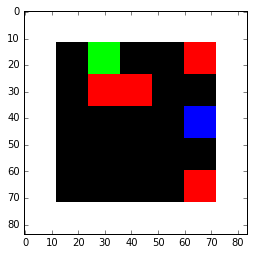

In [4]:
from gridworld_v02 import gameEnv
env = gameEnv(partial=False, size=5)

In [5]:
class Qnetwork():
    def __init__(self, h_size, name = "main"): #// h_size is the number of activation of conv4 
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutinoal layers.
        self.net_name = name
        self.scalarInput = tf.placeholder(shape=[None,84*84*3], dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        
        self.conv1 = slim.conv2d(inputs=self.imageIn,
                                 num_outputs=32,
                                 kernel_size=[8,8],
                                 stride=[4,4],
                                 padding='VALID', 
                                 biases_initializer = None)
        
        self.conv2 = slim.conv2d(inputs=self.conv1,
                                 num_outputs=64,
                                 kernel_size=[4,4],
                                 stride=[2,2],
                                 padding='VALID',
                                 biases_initializer = None)
        
        self.conv3 = slim.conv2d(inputs=self.conv2,
                                 num_outputs=64,
                                 kernel_size=[3,3],
                                 stride=[1,1],
                                 padding='VALID',
                                 biases_initializer = None)
        
        self.conv4 = slim.conv2d(inputs=self.conv3,
                                 num_outputs=h_size,
                                 kernel_size=[7,7],
                                 stride=[1,1],
                                 padding='VALID',
                                 biases_initializer = None)
        
        #We take the output from the final convolutional layer and split it into separated terms: advantage & value
        self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
        self.streamA = slim.flatten(self.streamAC)
        self.streamV = slim.flatten(self.streamVC)
        
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        self.AW = tf.Variable(xavier_init([h_size//2, env.actions]))
        self.VM = tf.Variable(xavier_init([h_size//2, 1]))
        
        self.Advantage = tf.matmul(self.streamA, self.AW)
        self.Value = tf.matmul(self.streamV, self.VM)
        
        #Then combine to obtain the final Q-value //why substract mean from Advantage?
        self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1, keep_dims=True))
        self.predict = tf.argmax(self.Qout, 1)
        
        #Obtain the loss by taking the sum of squares difference between the target and predicted Q values
        self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32) #// env.actions is probably number of actions
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)    
    

In [6]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)#// remove the necesary entries to make place for new experience
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5]) # buffer is experience tuple (size 4) plus "done" signal

In [7]:
def processState(states):
    return np.reshape(states,[84*84*3])

In [8]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    
    for idx,var in enumerate(tfVars[0:total_vars//2]): #// select the first half of the variables (the one that belong to the action choosing net) 
        op_holder.append(
            tfVars[idx+total_vars//2].assign(
                (var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))#// basically take values from the primary net and modify then slithly with values from the second net, then return then for later use of model update 
    
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)  

In [9]:
def get_copy_var_ops(*, dest_scope_name="target", src_scope_name="main"):
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
        
    return op_holder

In [25]:
#Set all the training parameters
batch_size = 32 #Number of experiences to use for each training step
update_freq = 10 #Frequency of a train step

y = .99 #Discount factor on the target Q-values

startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
#anneling_steps = 10000. #Number of training steps to decrease the explorarion parameter e 
anneling_steps = 5000

#num_episodes = 3*10000 #Number of episodes of the game environmet on which to train the network
num_episodes = 5000
#pre_train_steps = 10000 #Number of random action steps before training begins
pre_train_steps = 10000

#max_epLength = 100 #Maximun allowed length of a game episode
max_epLength = 50

load_model = True #Wheter to load a saved model
path = "./dqn_logs_testing" #Directory for checkpoints
#log_path = "./dqn_logs/logs" #Directory for logs

h_size = 512 #Number of activations of final conv layer

tau = 0.001 #Rate of update of target network values onto the primary network

#f = open(log_path,'w')

In [26]:
tf.reset_default_graph()

#Network instances
mainQN = Qnetwork(h_size, name="main")
targetQN = Qnetwork(h_size, name="target")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease
e = startE
stepDrop = (startE - endE)/anneling_steps

#Create lists to contain total reward and steps per episode
jList = []
rList = []
total_steps = 0

#Create path for checkpoints
if not os.path.exists(path):
    os.makedirs(path)

In [31]:
def replay_train(trainBatch):
    #print("traingBatch shape" + str(trainBatch.shape))

    #Perform the Double-DQN update to the target Q-values
    Q1 = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
    #print("Q1" + str(np.vstack(trainBatch[:,3])))

    Q2 = sess.run(targetQN.Qout, feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
    end_multiplier = -(trainBatch[:,4]-1)
    #print("Q2" + str(Q2))

    doubleQ = Q2[range(batch_size), Q1]
    targetQ = trainBatch[:,2] + (y * doubleQ * end_multiplier)

    #Update the network with our target values
    return sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), mainQN.targetQ:targetQ,
                          mainQN.actions:trainBatch[:,1]})


In [ ]:
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        if i%100 == 0:
            print("\n=====" + "Episode " + str(i) + "start =====" )
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    _ = sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                    
                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
            rAll += r
            s = s1
            
            if d == True:

                break
        
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")


=====Episode 0start =====
Saved Model
117 -0.2 1
296 -0.3 1
371 -0.8 1
558 -0.6 1
627 -0.6 1
683 -0.6 1
753 -0.8 1
830 -0.8 1
923 -0.6 1
1036 -0.8 1

=====Episode 100start =====
1102 -0.4 1
1178 -0.8 1
1241 -0.6 1
1325 -0.8 1
1466 -0.8 1
1503 -0.6 1
1565 -0.6 1
1671 -0.4 1
1771 -0.6 1
1877 -0.8 1

=====Episode 200start =====
1943 0.0 1
2045 -1.0 1
2105 -0.6 1
2200 -1.0 1
2276 -0.6 1
2350 -0.6 1
2452 -0.6 1
2554 -0.7 1
2641 -0.8 1
2697 -0.6 1

=====Episode 300start =====
2765 -0.8 1
2816 -0.8 1
2913 -0.8 1
3076 -1.0 1
3144 -1.0 1
3253 -0.8 1
3359 0.1 1
3433 -0.4 1
3548 -0.8 1
3633 -0.8 1

=====Episode 400start =====
3683 -0.8 1
3739 -0.6 1
3811 -0.8 1
3916 -0.8 1
4016 -0.4 1
4135 -0.3 1
4285 -0.7 1
4409 -0.5 1
4541 -0.8 1
4597 -0.8 1

=====Episode 500start =====
4679 -0.4 1
4725 -0.4 1
4864 -0.4 1
4999 -0.5 1
5133 -0.6 1
5237 -0.4 1
5327 -0.8 1
5383 -0.8 1
5520 -0.3 1
5578 -0.8 1

=====Episode 600start =====
5762 -0.4 1
5838 -0.4 1
5905 -1.0 1
5992 -0.6 1
6035 -0.2 1
6150 -0.4 1
6281 -

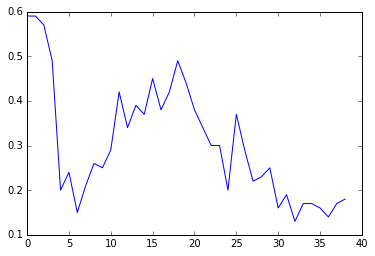

In [20]:
rMat = np.resize(np.array(rList), [len(rList)//100,100])
rMean = np.average(rMat, 1)
plt.plot(rMean)

------------------------------------

## Testing the network performance

This first piece of code aims to make a step by step walkthrough the game to see what actions is taken
For some reason the actor is performing a single action. Need to debug.

In [28]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

In [29]:
sess = tf.InteractiveSession()

In [30]:
ckpt = tf.train.get_checkpoint_state(path)
saver.restore(sess, ckpt.model_checkpoint_path)    

INFO:tensorflow:Restoring parameters from ./dqn_logs_testing/model-99999.cptk


[2017-06-04 14:54:29,699] Restoring parameters from ./dqn_logs_testing/model-99999.cptk


In [31]:
#Reset environment and get the first new observation
s = env.reset()
s = processState(s)
d = False
rAll_t = 0
j_t = 0        

Action: 1
Reward: 0 , Done: False


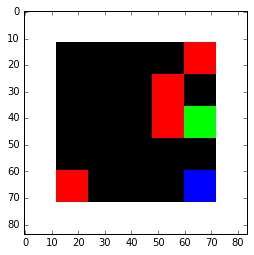

In [41]:
#Choose an action by greedily picking from the Q-net
a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns

print ("Action: %d" % a)
s1, r, d = env.step(a)
print ("Reward: %d , Done: %s" % (r, d))
plt.imshow(s1, interpolation = "nearest")
s1 = processState(s1)#// flatten the return frame
total_steps_t += 1
                        
rAll_t += r
s = s1


if d == True:
    print("End of training episode")
    jList_t.append(j_t)
    rList_t.append(rAll_t)
            
    if len(rList_t) % 10 == 0:
        accumR = np.mean(rList_t[-10:])
        log = str(total_steps_t) +"\t"+ str(accumR) 
        print(log)            

In [26]:
sess.close()

Test the actor in an automatic way. The issue is the same, the actor chooses the same action constantly

In [43]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

# Test setting parameters
load_model = True
num_test_episodes = 1000

#Create lists to contain total reward and steps per episode
with tf.Session() as sess:
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    for i in range(num_test_episodes):
        
        #Reset environment and get the first new observation
        s = env.reset()
        s = processState(s)
        d = False
        rAll_t = 0
        j_t = 0
        
        #Q-Network
        while j_t < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trail
            j_t+=1
            
            #Choose an action by greedily picking from the Q-net
            a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                        
              
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
            #f.write(log)
                
    
final_log = "Percent of sucessful episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

Loading Model...
INFO:tensorflow:Restoring parameters from ./dqn_logs_testing/model-99999.cptk


[2017-06-04 14:55:30,188] Restoring parameters from ./dqn_logs_testing/model-99999.cptk


403	-0.2
621	-0.6
927	-0.2
1091	0.1
1348	-0.1
1705	-0.3
2064	-0.1
2278	-0.2
2585	-0.4
2894	-0.2
3347	-0.1
3709	-0.1
4063	-0.3
4465	0.0
4780	-0.4
5136	0.1
5397	-0.5
5799	-0.2
6160	-0.1
6419	-0.1
6681	-0.3
6994	-0.2
7249	-0.3
7412	-0.3
7720	0.0
8126	-0.2
8384	-0.5
8786	-0.2
9144	-0.1
9402	0.1
9520	-0.4
9783	-0.3
10042	-0.1
10445	-0.2
10798	-0.3
11059	-0.5
11318	-0.1
11671	-0.3
11934	-0.5
12291	-0.3
12645	-0.1
13050	-0.2
13264	-0.4
13624	-0.3
13935	-0.2
14290	-0.1
14549	-0.5
14807	-0.1
15213	-0.2
15566	-0.3
15872	-0.4
16129	-0.1
16482	-0.1
16746	-0.5
17149	-0.2
17456	-0.4
17763	-0.4
18068	-0.4
18423	0.1
18729	-0.2
19131	0.0
19255	-0.6
19660	-0.2
19921	-0.3
20234	-0.4
20541	-0.4
20753	-0.6
21107	-0.3
21316	0.0
21670	0.1
21930	-0.3
22100	-0.3
22455	0.1
22859	-0.2
23070	-0.4
23284	-0.6
23643	-0.1
23857	-0.4
24213	-0.3
24476	-0.3
24644	-0.3
25001	-0.1
25263	-0.3
25617	-0.1
25780	-0.7
26234	-0.1
26589	-0.1
26849	-0.3
27252	-0.2
27559	-0.2
27917	-0.3
28224	-0.2
28482	-0.5
28884	-0.2
29145	-0.3


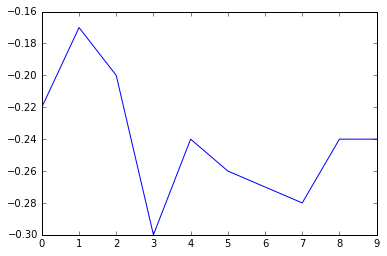

In [44]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)

---------------------------------------------

## Test Random Actor

In [45]:
# Test setting parameters for random actor
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

_,_ = env.checkGoal()

with tf.Session() as sess:
    sess.run(init)
        
    for i in range(num_test_episodes):
        
        d = False
        rAll_t = 0
        j_t = 0
        
        while j_t < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trail
            j_t += 1
            
            a = np.random.randint(0,4)
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                      
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
                           
    
final_log = "Percent of sucessful test episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

186	-0.9
276	-1.0
386	-0.8
459	-0.2
588	-0.8
773	-0.6
886	-0.7
944	-0.8
1055	-0.4
1178	-0.8
1292	-1.0
1424	-1.0
1514	-0.8
1567	-0.6
1670	-0.6
1758	-0.8
1948	-0.6
2054	-1.0
2160	-0.8
2274	-0.2
2373	-0.8
2465	-0.8
2587	-0.6
2663	-1.0
2740	-0.8
2858	-0.2
2982	-0.8
3088	-0.6
3190	-1.0
3252	-0.6
3323	-1.0
3500	-0.9
3586	-0.8
3641	-1.0
3730	-1.0
3798	-0.8
3860	-0.8
4005	-0.8
4151	-0.9
4201	-0.8
4349	-1.0
4446	-0.8
4615	-0.8
4738	-0.5
4870	-0.6
4958	-0.8
5075	-1.0
5229	-0.8
5310	-1.0
5410	-0.8
5467	-1.0
5573	-1.0
5739	-0.6
5876	-1.0
5948	-1.0
6023	-0.8
6114	-0.8
6191	-0.4
6282	-0.4
6398	-1.0
6472	-0.8
6549	-1.0
6621	-1.0
6697	-0.8
6739	-0.6
6822	-0.8
6880	-0.6
7025	-0.6
7151	-0.8
7246	-1.0
7316	-0.8
7423	-0.6
7575	-0.5
7652	-1.0
7723	-0.6
7770	-0.8
7863	-0.6
8009	-0.8
8081	-0.8
8177	-0.8
8258	-0.8
8366	-0.7
8460	-0.8
8527	-0.8
8621	-1.0
8762	-0.8
8901	-0.7
9061	-0.5
9148	-0.8
9210	-1.0
9315	-0.8
9399	-0.8
9489	-0.8
9612	-0.8
9736	-0.7
9864	-0.8
9997	-1.0
10144	-0.6
10245	-1.0
10385	-0.7
10450

KeyboardInterrupt: 

In [ ]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)